# Redes Neuronales Recurrentes

**Nombre:** Brayan Simpon Polo Orellana

**GitHub:** https://github.com/bspoloo/SIS421-022025/tree/main/Laboratorios/Laboratorio%203

Para este laboratorio se Construyo una red neuronal recurrente, para inferir los valores futuros a partir del dataset.

El dataset usado para este laboratorio se uso el dataset `Did it rain in Seattle? (1948-2017)`: 

Además de las empresas de café, grunge y tecnología, una de las cosas por las que Seattle es más famosa es la frecuencia con la que llueve. Este conjunto de datos contiene registros completos de los patrones diarios de lluvia desde el 1 de enero de 1948 hasta el 12 de diciembre de 2017:

Estos datos se recopilaron en el Aeropuerto Internacional de Seattle-Tacoma. El conjunto de datos contiene cinco columnas:

- **DATE** = fecha de la observación
- **PRCP** = cantidad de precipitación, en pulgadas
- **TMAX** = temperatura máxima de ese día, en grados Fahrenheit
- **TMIN** = temperatura mínima de ese día, en grados Fahrenheit
- **RAIN** = VERDADERO si se observó lluvia ese día, FALSO si no

https://www.kaggle.com/datasets/rtatman/did-it-rain-in-seattle-19482017

## Importacion de librerias necesarias para el modelo

In [380]:
# utilizando la libreria os para manejos de directorios
import os

# Computacion vectorial y cientifica para python
import numpy as np

#importamos pandas para el manejo del dataset, y separarlos dentro de una matriz
import pandas as pd

from tqdm import tqdm
import numpy as np
import torch

# Librerias para graficación (trazado de gráficos)
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # -> Necesario para graficar superficies 3D

#Para separa el 20% y 80%
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
from torch.utils.data import Dataset, DataLoader

## Lectura del Dataset

Podemos observar que se nos muestran todos los datos necesarios, desde la fecha en formato YY-MM-DD, pero lo que nos interesa aqui es el valor de la precipitacion, ya que el valor se tomo cada dia desde 1948 hasta 2017:

In [381]:
df = pd.read_csv('seattleWeather_1948-2017.csv', delimiter=',')
df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [382]:
df["DATE"] = pd.to_datetime(df["DATE"], format="%Y-%m-%d")
df.set_index("DATE", inplace=True)

Graficamos como se comporta el valor de la *Precipitacion* con respecto a la fecha, se nos observa variantes debido a que los datos aumentaban o disminuian con el paso del registro diario, esto con un total de 25.000 registros diarios:

El tamaño total del dataset es: 25551


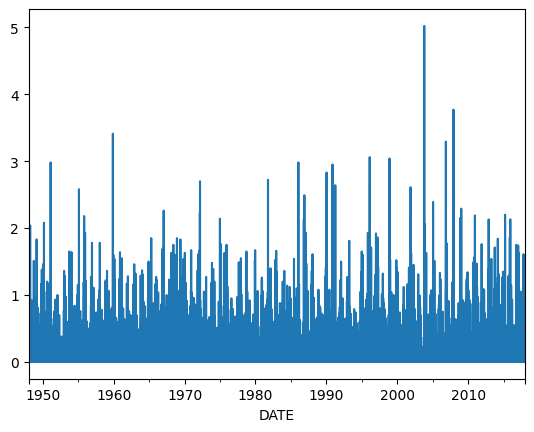

In [383]:
df["PRCP"].plot()
print(f"El tamaño total del dataset es: {len(df)}")

## Creacion de Secuencias

La función `create_sequences` sirve para transformar una serie temporal (por ejemplo, una lista de valores de precipitación) en secuencias de datos:
Explicación paso a paso:

- **Entrada:**  
    - `values`: array o lista de valores (por ejemplo, valores de precipitación).
    - `n_steps`: número de pasos (longitud de la ventana) que quieres usar para cada secuencia.

- **Proceso:**  
    - Recorre los datos y, para cada posición, toma una ventana de tamaño `n_steps` como entrada (`X`) y el valor siguiente como salida (`y`).
    - Por ejemplo, si `n_steps=3` y tus datos son `[10,20,30,40,50]`, las secuencias serán:
        
        La función genera:
        - Iteración 0 →
            X = [10, 20, 30], y = 40

        - Iteración 1 →
            X = [20, 30, 40], y = 50

- **Salida:**  
    - Devuelve dos arrays de numpy:  
        - `X`: matriz de secuencias (cada fila es una ventana de tamaño `n_steps`)
        - `y`: vector de valores objetivo (el valor siguiente a cada ventana)

Esta transformación es fundamental para preparar datos de series temporales para modelos que predicen el siguiente valor a partir de los anteriores.

In [384]:
import numpy as np

def create_sequences(values, n_steps):
    X, y = [], []
    for i in range(len(values) - n_steps):
        X.append(values[i:i+n_steps])
        y.append(values[i+n_steps])
    return np.array(X), np.array(y)

significa que tienes 1000 muestras, cada una con una ventana de 30 pasos y 1 característica por paso.

- **Forma:** (num_muestras, n_steps, num_features)
- **num_muestras:** cuántas ventanas deslizantes se pudieron crear.
- **n_steps:** el número de pasos hacia atrás (en mi caso 30 días).
- **num_features:** cuántas variables tiene cada paso (aquí solo PRCP, así que =1).

In [385]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Extraer la serie de precipitación
values = df["PRCP"].values.reshape(-1, 1)
scaler = MinMaxScaler()
values = scaler.fit_transform(values)

n_steps = 30
X, y = create_sequences(values, n_steps)

print("Total X shape:", X.shape)
print("Total y shape:", y.shape)

Total X shape: (25521, 30, 1)
Total y shape: (25521, 1)


In [386]:
# Usar proporciones similares (70% train, 20% valid, 10% test)
train_size = int(len(X) * 0.7)
valid_size = int(len(X) * 0.2)

X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size+valid_size], y[train_size:train_size+valid_size]
X_test, y_test   = X[train_size+valid_size:], y[train_size+valid_size:]

print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (17864, 30, 1) (17864, 1)
Valid: (5104, 30, 1) (5104, 1)
Test: (2553, 30, 1) (2553, 1)


El objetivo es predecir el último valor de la serie temporal a partir de todos los anteriores. De ser capaces de llevar a cabo esta tarea podríamos predecir la precipitacion de lluvia:

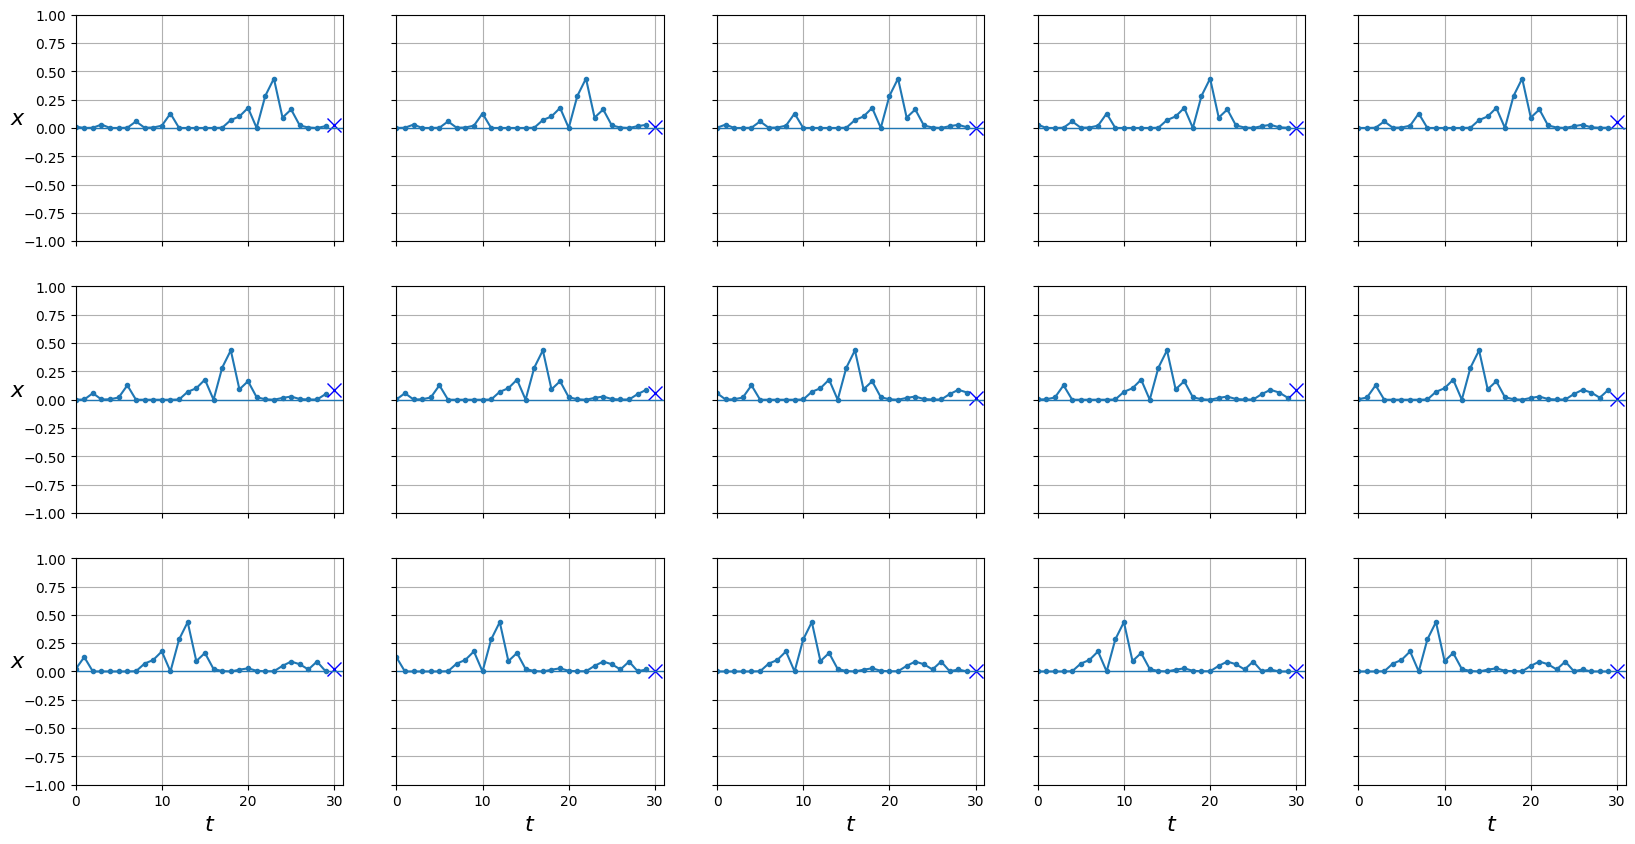

In [387]:
import matplotlib.pyplot as plt

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

plot_series(X_test, y_test)

In [388]:
y_pred = X_test[:,-1]
mean_squared_error(y_test, y_pred)

0.0035587010279613503

Mostrando el último valor:

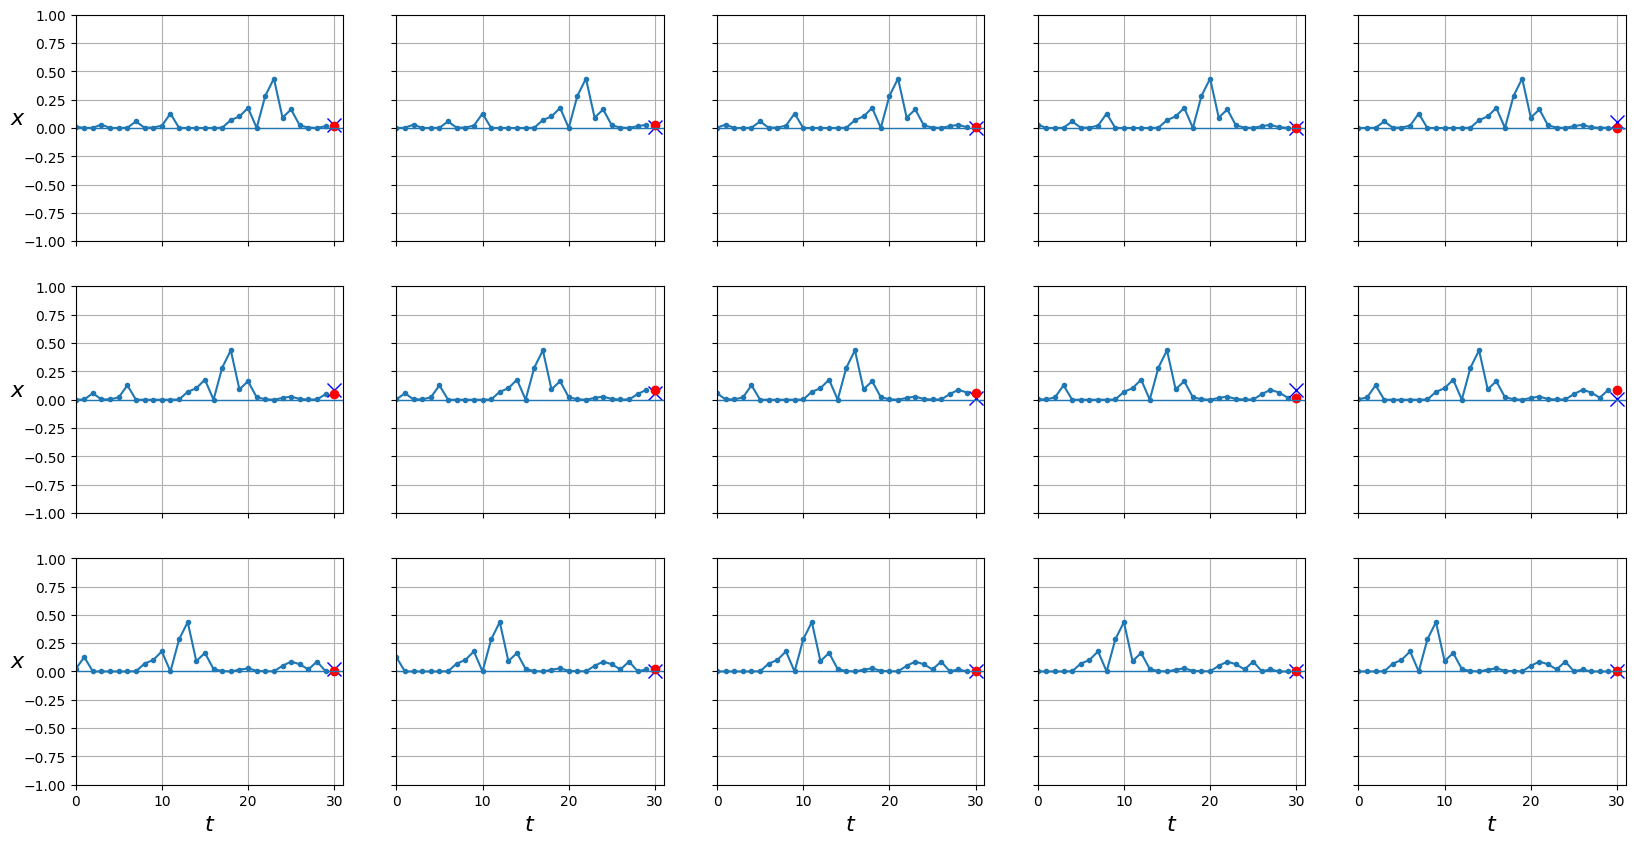

In [389]:
y_pred = X_test[:,-1]
plot_series(X_test, y_test, y_pred)

## RNN Simple

Esta clase es una red recurrente muy básica que:

- Lee una secuencia de valores (ej: 30 días de lluvia).
- Pasa por una capa RNN con un estado oculto de dimensión 1.
- Devuelve solo la última salida de la secuencia (la predicción para el día siguiente).

**Capa RNN (torch.nn.RNN)**

- ``input_size=1:`` cada paso temporal solo tiene 1 valor (por ejemplo, la precipitación diaria).
- ``hidden_size=1:`` el estado oculto tendrá dimensión 1 → un modelo muy simple.
- ``num_layers=1:`` solo una capa RNN, nada apilado.
- ``batch_first=True: ``la entrada se espera como (batch, seq_len, features) en lugar de (seq_len, batch, features).

Método forward:

x, h = self.rnn(x)
- ``x:`` contiene la salida de cada paso temporal → forma (batch, seq_len, hidden_size).
- ``h:`` es el último hidden state → forma (num_layers, batch, hidden_size).
- ``x[:,-1]:`` selecciona solo la salida del último paso temporal (el último día de la secuencia), que es lo que interesa para la predicción.

In [390]:
import torch

class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x)
    # solo queremos la última salida
    return x[:,-1]

In [391]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
srnn = SimpleRNN()

Using cuda


### Función de Entrenamiento `fit`

La función `fit` se encarga de **entrenar y evaluar** un modelo de PyTorch durante un número definido de épocas.  
Su estructura sigue el ciclo clásico de **entrenamiento + validación** en deep learning.

### Parámetros
- **model**: la red neuronal a entrenar (ejemplo: `SimpleRNN` o `LSTM`).  
- **dataloader**: un diccionario que contiene:
  - `dataloader['train']`: lotes de datos para entrenamiento.  
  - `dataloader['eval']`: lotes de datos para validación.  
- **epochs** *(int, opcional)*: número de épocas (iteraciones completas sobre los datos). Por defecto `10`.

### Proceso
1. **Configuración inicial**
   - Se envía el modelo al dispositivo (`cpu` o `cuda`).
   - Se define el **optimizador** Adam.
   - Se define la **función de pérdida** `MSELoss` (Error cuadrático medio), adecuada para problemas de regresión.

2. **Entrenamiento (por cada época)**
   - El modelo entra en modo entrenamiento (`model.train()`).
   - Para cada batch:
     - Se pasan los datos a GPU/CPU.
     - Se hace una predicción (`y_hat = model(X)`).
     - Se calcula la pérdida (`loss = criterion(y_hat, y)`).
     - Se hace backpropagation (`loss.backward()`).
     - Se actualizan los parámetros (`optimizer.step()`).
   - Se guarda la **pérdida promedio** de la época (`train_loss_mean`).

3. **Evaluación**
   - El modelo pasa a modo evaluación (`model.eval()`).
   - Se desactiva el cálculo de gradientes (`torch.no_grad()`).
   - Para cada batch de validación:
     - Se predice y se calcula la pérdida.
   - Se guarda la **pérdida promedio** en validación (`val_loss_mean`).

4. **Seguimiento**
   - Se muestran las pérdidas en la barra de progreso con `tqdm`.
   - Se guardan las pérdidas de entrenamiento y validación en listas.

### Retorno
- `train_losses`: lista con la pérdida promedio de entrenamiento en cada época.  
- `val_losses`: lista con la pérdida promedio de validación en cada época.  


In [392]:
def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    train_losses = []
    val_losses = []

    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        # --- Entrenamiento ---
        model.train()
        epoch_train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            epoch_train_loss.append(loss.item())
        train_loss_mean = np.mean(epoch_train_loss)
        train_losses.append(train_loss_mean)

        # --- Evaluación ---
        model.eval()
        epoch_val_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                epoch_val_loss.append(loss.item())
                # break

        val_loss_mean = np.mean(epoch_val_loss)
        val_losses.append(val_loss_mean)

        bar.set_description(f"loss {train_loss_mean:.5f} val_loss {val_loss_mean:.5f}")

    # Retornar losses completos
    return train_losses, val_losses


### Función de Predicción `predict`

La función `predict` se utiliza para **generar predicciones** con un modelo ya entrenado.  
No realiza entrenamiento, solo **forward pass** (propagación hacia adelante).

### Parámetros
- **model**: el modelo entrenado de PyTorch (ejemplo: `SimpleRNN`, `LSTM`).  
- **dataloader**: lote(s) de datos de entrada para los que queremos obtener predicciones.  
  - Puede ser un `DataLoader` o un simple iterador de tensores.  
  - Si contiene `y`, se ignora (se toma solo `X`).

### Proceso
1. **Modo evaluación**  
   - Se coloca al modelo en `model.eval()` para desactivar capas como `Dropout` o `BatchNorm` en entrenamiento.

2. **Desactivación de gradientes**  
   - Se usa `torch.no_grad()` para ahorrar memoria y acelerar la inferencia (no necesitamos backpropagation).

3. **Bucle de predicción**
   - Inicializa un tensor vacío `preds` donde se irán acumulando las predicciones.
   - Para cada batch del `dataloader`:
     - Si el batch viene en forma `(X, y)`, solo se toma `X`.
     - Los datos se envían al dispositivo (`cpu` o `cuda`).
     - Se calcula la salida `pred = model(X)`.
     - Se concatenan las predicciones al tensor `preds`.

4. **Retorno**
   - Devuelve todas las predicciones concatenadas en un solo tensor.  
   - (Nota: se puede convertir a `numpy` con `.cpu().numpy()` para graficar).

### Ejemplo de uso
```python
# Generar predicciones con el modelo entrenado
preds = predict(model, dataloader['eval'])

# Convertir a numpy para graficar
preds = preds.cpu().numpy()

plt.plot(preds, label="Predicciones")
plt.plot(y_true, label="Valores reales")  # si tienes las etiquetas
plt.legend()
plt.show()


In [393]:
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            # Para test dataset que no tiene y
            if isinstance(batch, (tuple, list)):
                X = batch[0]
            else:
                X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds # convertir a numpy para graficar

### Clase `TimeSeriesDataset`

Esta clase define un **Dataset personalizado** para PyTorch, pensado para trabajar con **series temporales** (como nuestra serie de precipitación `PRCP`).  
Permite usar los objetos `DataLoader` de PyTorch para manejar **mini-batches**, barajar datos y simplificar el entrenamiento.

In [394]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y=None, train=True):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32) if y is not None else y
        self.train = train

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        if self.train:
            return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
        return torch.from_numpy(self.X[ix])


### Preparación de Datasets y DataLoaders

En este bloque se **crean los datasets y los dataloaders** para PyTorch a partir de las secuencias de entrenamiento, validación y test.

In [395]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [396]:
print(len(dataset['eval']))
print(next(iter(dataloader['eval']))[0].shape)  # Primer batch

5104
torch.Size([64, 30, 1])


## Entrenamiento del Modelo, Visualización de Loss y Predicciones

En este bloque se realiza el **entrenamiento de la RNN**, se grafica la evolución de la pérdida y se generan predicciones sobre el conjunto de prueba.


loss 0.00195 val_loss nan: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


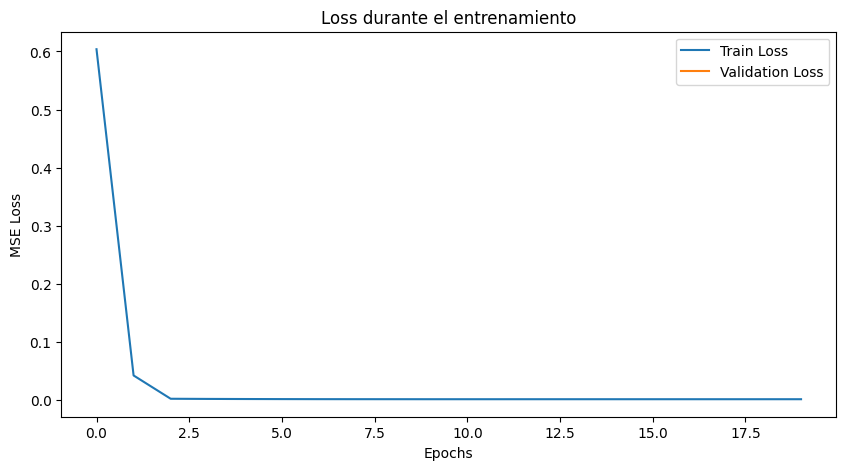

In [397]:
train_losses, val_losses = fit(srnn, dataloader, epochs=20)

# Graficar loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Loss durante el entrenamiento")
plt.legend()
plt.show()

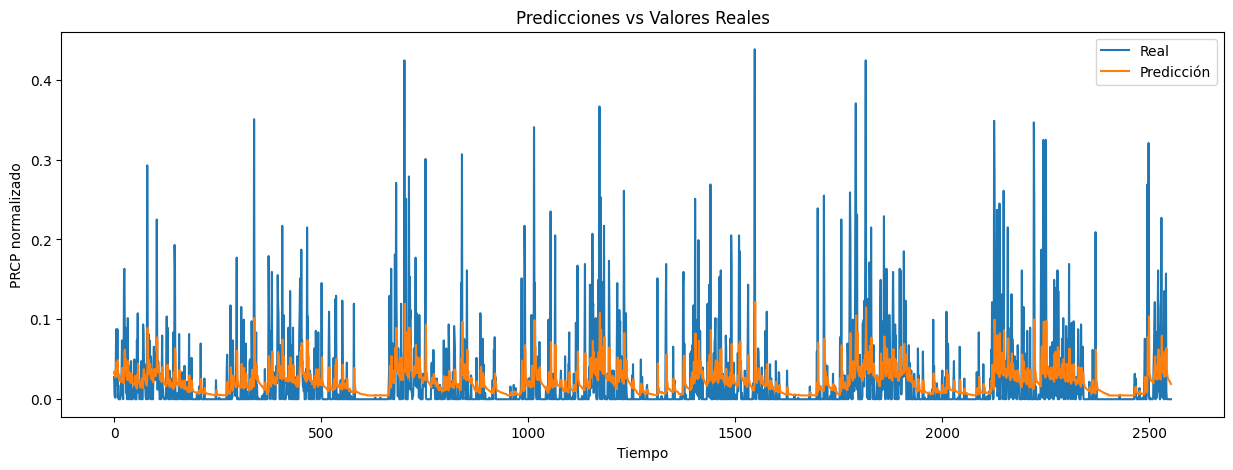

In [398]:
y_pred = predict(rnn, dataloader['test']).cpu().numpy()
y_true = y_test

plt.figure(figsize=(15,5))
plt.plot(y_true, label="Real")
plt.plot(y_pred, label="Predicción")
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Tiempo")
plt.ylabel("PRCP normalizado")
plt.legend()
plt.show()

## Clase `RNN` con Capa Lineal

Esta clase define un modelo recurrente más avanzado que la `SimpleRNN`, con **más unidades ocultas** y una capa **fully connected (Linear)** para generar la predicción final.
**- x, h = self.rnn(x):**

- **x:** salida de la RNN en cada paso temporal → (batch, seq_len, hidden_size).
- **h:** último hidden state → (num_layers, batch, hidden_size) (no se usa directamente aquí).
- **x[:,-1]:** selecciona solo la última salida de la secuencia.
- **self.fc(x[:,-1]):** la pasa por la capa lineal para obtener la predicción final.

In [399]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=40, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(40, 1)

  def forward(self, x):
    x, h = self.rnn(x)
    # get the last output and apply linear layer
    y = self.fc(x[:,-1])
    return y

In [400]:
rnn = RNN()
rnn.rnn.weight_hh_l0.shape, 
rnn.rnn.weight_ih_l0.shape, 
rnn.rnn.bias_hh_l0.shape, 
rnn.rnn.bias_ih_l0.shape, 
rnn.fc.weight.shape, 
rnn.fc.bias.shape

torch.Size([1])

loss 0.00191 val_loss nan: 100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


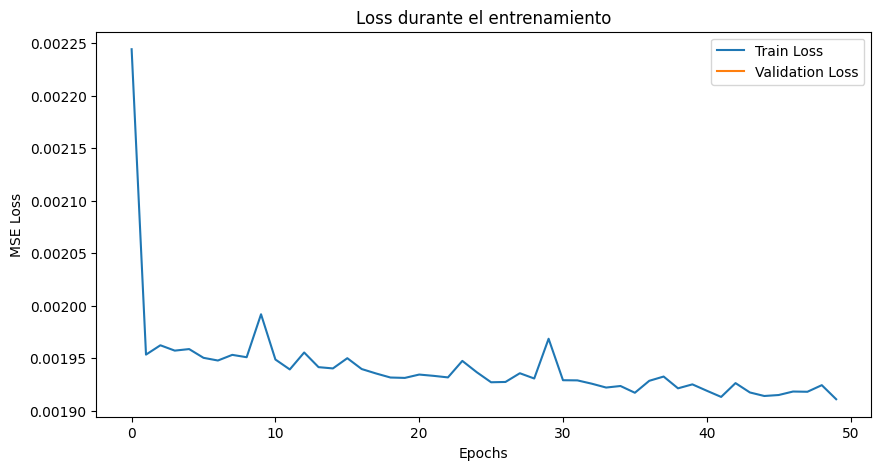

In [401]:
train_losses, val_losses = fit(rnn, dataloader, epochs=50)

# Graficar loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Loss durante el entrenamiento")
plt.legend()
plt.show()

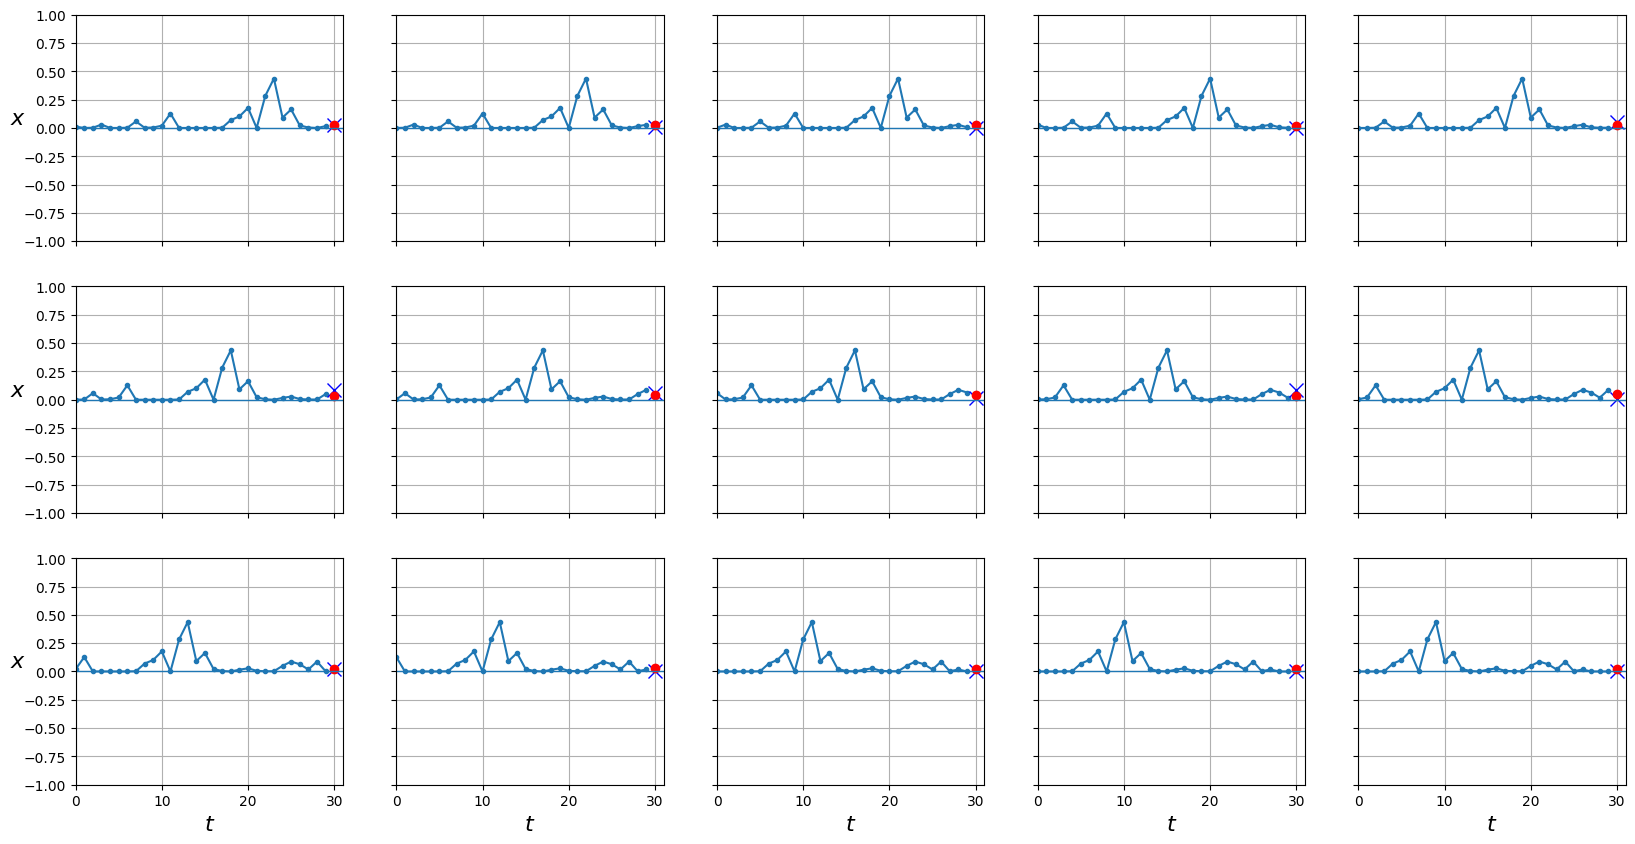

El error prediccion es: 0.0022941251701193285


In [402]:
y_pred = predict(rnn, dataloader['test']).cpu().numpy()
plot_series(X_test, y_test, y_pred)
error = mean_squared_error(y_test, y_pred)
print(f"El error prediccion es: {error}")

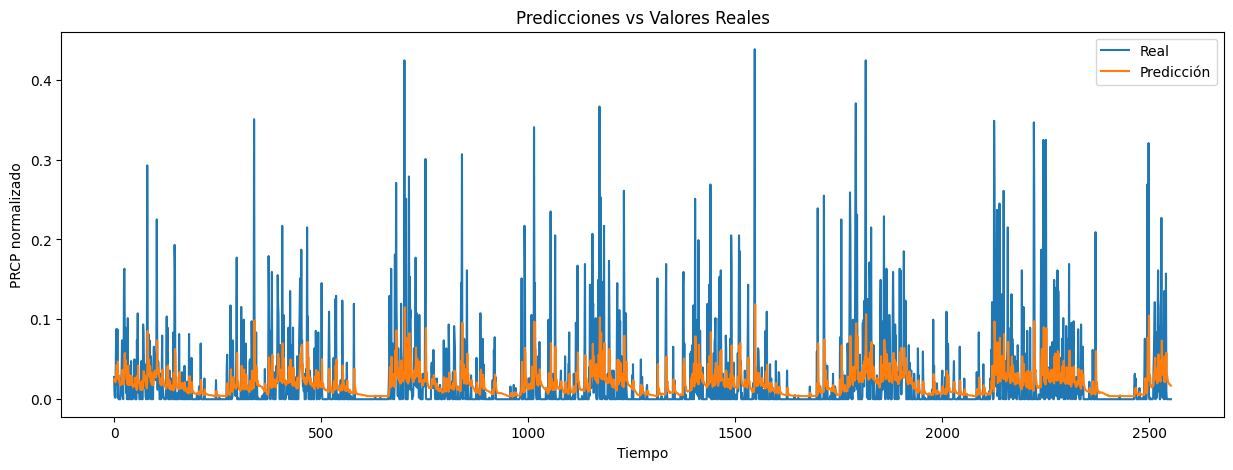

In [403]:
y_pred = predict(rnn, dataloader['test']).cpu().numpy()
y_true = y_test

plt.figure(figsize=(15,5))
plt.plot(y_true, label="Real")
plt.plot(y_pred, label="Predicción")
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Tiempo")
plt.ylabel("PRCP normalizado")
plt.legend()
plt.show()

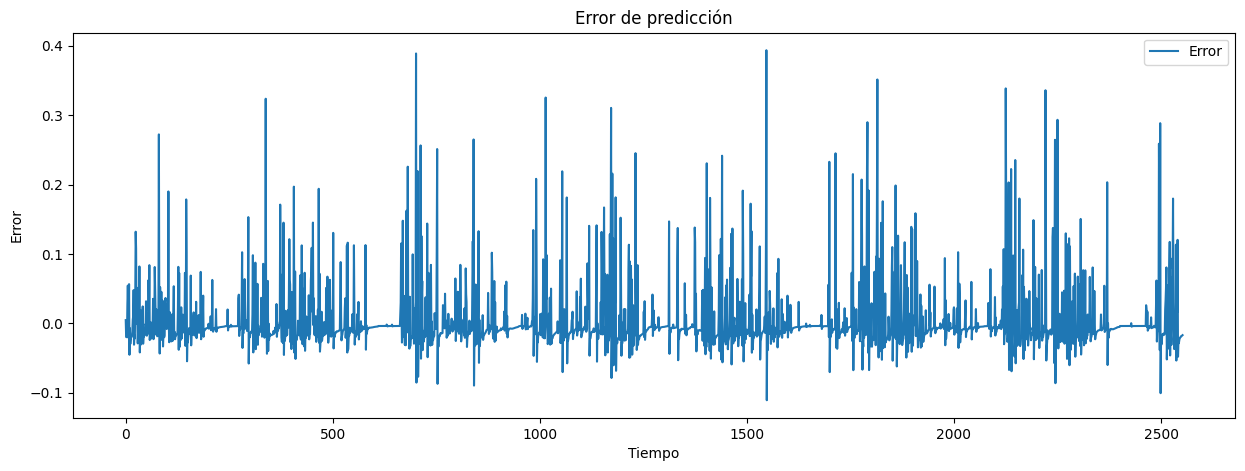

In [404]:
plt.figure(figsize=(15,5))
plt.plot(y_true - y_pred, label="Error")
plt.title("Error de predicción")
plt.xlabel("Tiempo")
plt.ylabel("Error")
plt.legend()
plt.show()